## 1. Import the necessary libraries

In [135]:
from gensim.models import Word2Vec, KeyedVectors
import numpy as np
from tqdm import tqdm
import pandas as pd
from keras.utils import to_categorical
from keras.utils import plot_model
from pyvi import ViTokenizer
import matplotlib.pyplot as plt
import import_ipynb
from data_preprocessing_sa import remove_punctuation, remove_stopword,remove_repeated_words
from keras.callbacks import EarlyStopping
from sklearn.manifold import TSNE
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization, LSTM, TimeDistributed,Input
from keras.models import load_model
from sklearn.preprocessing import LabelEncoder
import pickle
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,roc_curve,auc

## 2 Data preprocessing

> Read File CSV

In [136]:
def ReadData(path):
    df=pd.read_csv(path,encoding='utf-8')
    return df['comment'], df['label']

> Execute function

In [137]:
X_train,y_train = ReadData("../data/data_processed/trainprocessed.csv")
X_test,y_test=ReadData("../data/data_processed/testprocesssed.csv")

In [138]:
print(f"X_Train size:{X_train.shape}")
print(f"y_train size {y_train.shape}")

X_Train size:(8898,)
y_train size (8898,)


> word separation

In [139]:
def wordseparation(comment):
    return [review.split() for review in comment]

In [140]:
X_train=wordseparation(X_train)
X_test=wordseparation(X_test)
print(f"X_Train: {X_train[0:2]}")
print(f"X_test: {X_test[0:2]}")

X_Train: [['pin', 'kém', 'còn', 'miễn', 'chê', 'mua', '832019', 'tình_trạng', 'pin', 'còn', '88', 'ai', 'giống', 'tôi'], ['sao', 'gọi', 'điện_thoại', 'màn_hình', 'chấm', 'nhỏ', 'nháy', 'gần', 'camera', 'vậylúc']]
X_test: [['điện', 'thoải', 'ổn', 'facelock', 'cực', 'nhanh', 'vân', 'tay', 'ôk', 'màn_hình', 'lớn', 'pin', 'trâu', 'liên_quân', 'zalo', 'youtube', 'một', 'ngày', 'mất', 'khoảng', '45', 'tuy', 'chip', '439', 'mượt', 'đa_nhiệm', 'khá', 'ổn'], ['mình', 'mới', 'mua', 'vivo91c', 'tải', 'ứng_dụng', 'games', 'nhanh', 'hài_lòng', 'cài', 'hình', 'nền', 'khóa', 'màn_hình', 'hay', 'mình', 'biết', 'hết', 'chức_năng', 'nó', 'tư_vấn', 'viên', 'nhiệt_tình']]


> word embedding

In [141]:
model_wordembedding = Word2Vec(sentences=X_train, vector_size=20, window=5, min_count=0, workers=4, sg=1)
model_wordembedding.wv.save("../model/word.model")

> Load Model_Word2Vec

In [142]:
model_embedding = KeyedVectors.load('../model/word.model')
num_words = len(model_embedding.index_to_key)
print("Number of Words:", num_words)
print("Vector:", model_embedding.get_vector('phần_mềm'))

Number of Words: 12550
Vector: [ 0.14748614 -0.31362966  0.50426424  0.25543734 -0.4532953   0.09542754
 -0.5582688   0.6890423  -0.06788978  0.38939238  0.52902806 -1.3193789
  0.33723736 -0.03381869  0.40523568  0.5932944   1.0914466  -0.38147518
 -0.5930539  -0.8418427 ]


> Get a list of vector representations of words

In [143]:
# Lấy danh sách các vectơ từ
vectors = [model_embedding.get_vector(word) for word in model_embedding.index_to_key]
vectors_array = np.array(vectors)
# Giảm chiều dữ liệu từ 20 chiều xuống còn 2 chiều bằng t-SNE
tsne = TSNE(n_components=2, random_state=42)
vectors_2d = tsne.fit_transform(vectors_array)
print(vectors_2d[0:2])

[[90.22153   -0.5081355]
 [86.94829   15.328544 ]]


> Visualize the context and semantic correlation of words

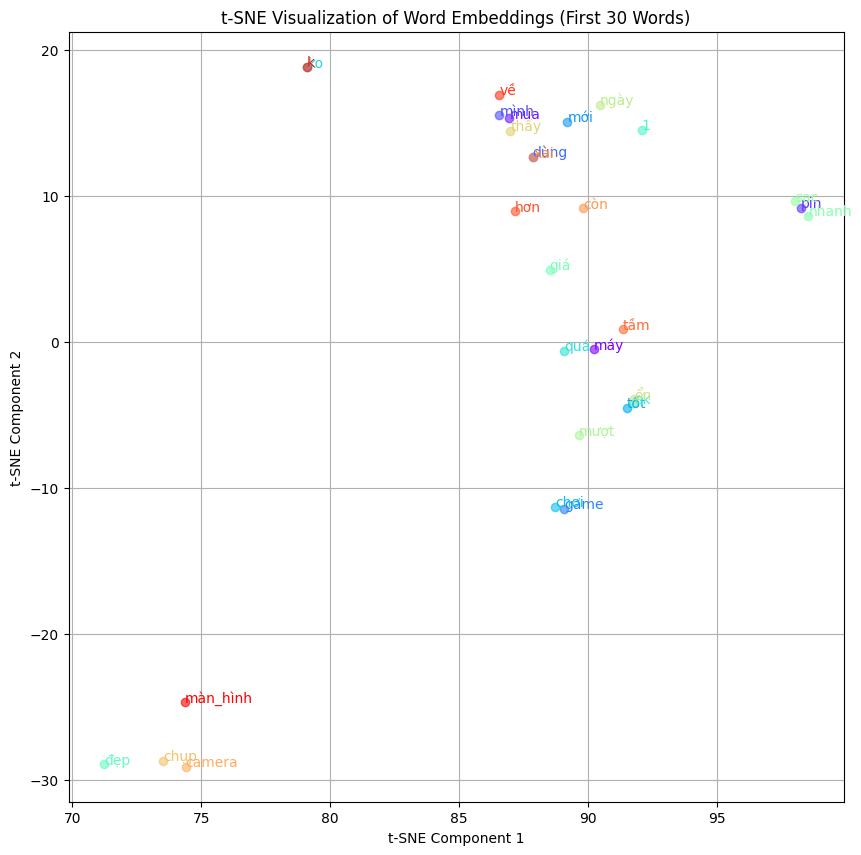

In [144]:
# Trực quan hóa các vectơ từ
plt.figure(figsize=(10, 10))
num_words = 30
# Màu cho mỗi từ
colors = plt.cm.rainbow(np.linspace(0, 1, num_words))

# Vẽ các điểm dữ liệu (từ) với màu khác nhau
for i, word in enumerate(model_embedding.index_to_key[:num_words]):  
    plt.scatter(vectors_2d[i, 0], vectors_2d[i, 1], marker='o', color=colors[i], alpha=0.6)
    plt.annotate(word, xy=(vectors_2d[i, 0], vectors_2d[i, 1]), fontsize=10, color=colors[i])

plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE Visualization of Word Embeddings (First 30 Words)')
plt.grid(True)
plt.show()


> Corpus

In [145]:
corpus=model_embedding.key_to_index

> Check to see how many words the longest sentence has

In [146]:
max_sequence = max([len(seq) for seq in X_train])
max_sequence_t=max ([len(seq) for seq in X_test ])
print(max_sequence)
print(max_sequence_t)

128
131


> convert words to vector space and padding

In [147]:
def comment_embedding(comment):
    matrix = np.zeros((131, 20))
    for i, word in enumerate(comment):
            if word in model_embedding:
                matrix[i] = model_embedding.get_vector(word)
    return matrix

> Execute Function

In [148]:
train_data = []
test_data =[]
for x in tqdm(X_train):
    train_data.append(comment_embedding(x))
for y in tqdm(X_test): 
    test_data.append(comment_embedding(y))
test_data=np.array(test_data)
train_data=np.array(train_data)

100%|██████████| 2224/2224 [00:00<00:00, 28730.23it/s]


> Convert labels to numbers

In [149]:
label_encoder = LabelEncoder()
# Mã hóa các nhãn văn bản thành các giá trị số
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded=label_encoder.transform(y_test)
print(y_train_encoded[0:3])

[1 0 1]


> Convert label to one_hot_vector

In [150]:
# Biểu diễn nhãn dưới dạng one-hot vector
y_train_onehot = to_categorical(y_train_encoded)
print(y_train_onehot[0:3])

[[0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]]


## 3.Built Model CNN

### 3.1. Design configuration for CNN network

In [151]:
num_classes = 3
filter_sizes =(2,17)
num_filters = 2
epochs = 180
dropout_rate = 0.3
embedding_size=20
num_lstm_unit=7
pool_size=(3, 2)
strides=(3, 2)

> transform input properties

In [152]:
x_train = train_data.reshape(train_data.shape[0], 131, embedding_size, 1).astype('float32')

### 3.2. Model Hybrid CNN with LSTM

>

> Custom 

In [153]:
# Define the model
model = Sequential()
# Add a convolutional layer
model.add(Input(shape=(131, embedding_size, 1)))
model.add(Conv2D(num_filters, filter_sizes, activation='relu',
name='convolution_layer'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size,strides,name='max_pooling'))
model.add(TimeDistributed(Flatten()))
model.add(Dropout(dropout_rate,name='dropout_layer1'))
model.add(LSTM(num_lstm_unit, return_sequences=True,name='LSTM_layer1'))
model.add(Dropout(dropout_rate,name='dropout_layer2'))
model.add(LSTM(num_lstm_unit,name='LSTM_layer2'))
model.add(Dense(3, activation='softmax'))

### 3.3. Hyperparameter

In [154]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

### 3.4. Train

> Monitor the trainning process to stop earlier

In [155]:
early_stopping_callback = EarlyStopping(
    monitor='val_loss', 
    patience=35,          
    restore_best_weights=True  
)

In [156]:
history=model.fit(
    x_train,
    y_train_onehot,
    verbose=1,
    epochs=epochs,
    validation_split=0.2,
    batch_size=64,
    callbacks=[early_stopping_callback] 
)

Epoch 1/180
112/112 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.3748 - loss: 1.0547 - val_accuracy: 0.5056 - val_loss: 0.9640
Epoch 2/180
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.5133 - loss: 0.9484 - val_accuracy: 0.5056 - val_loss: 0.9533
Epoch 3/180
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.5303 - loss: 0.9421 - val_accuracy: 0.5062 - val_loss: 0.9488
Epoch 4/180
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.5130 - loss: 0.9491 - val_accuracy: 0.5062 - val_loss: 0.9493
Epoch 5/180
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.5208 - loss: 0.9537 - val_accuracy: 0.5062 - val_loss: 0.9480
Epoch 6/180
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.5201 - loss: 0.9362 - val_accuracy: 0.5185 - val_loss: 0.9523
Epoch 7/180
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.6038 - loss: 0.8792 - val_accuracy: 0.6938 - val_loss: 0.7796
Epoch 8/180
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.7178 - loss: 0.7411 - 

>Network Architecture

In [157]:
print(model.summary())

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ convolution_layer (Conv2D)      │ (None, 130, 4, 2)      │            70 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 130, 4, 2)      │             8 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling (MaxPooling2D)      │ (None, 43, 2, 2)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_12             │ (None, 43, 4)          │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_layer1 (Dropout)        │ (None, 43, 4)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_layer1 (LSTM)              │ (None, 43, 7)          │           336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_layer2 (Dropout)        │ (None, 43, 7)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_layer2 (LSTM)              │ (None, 7)              │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │            24 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,568 (10.04 KB)

 Trainable params: 854 (3.34 KB)

 Non-trainable params: 4 (16.00 B)

 Optimizer params: 1,710 (6.68 KB)

None


> Network Architecture Diagram

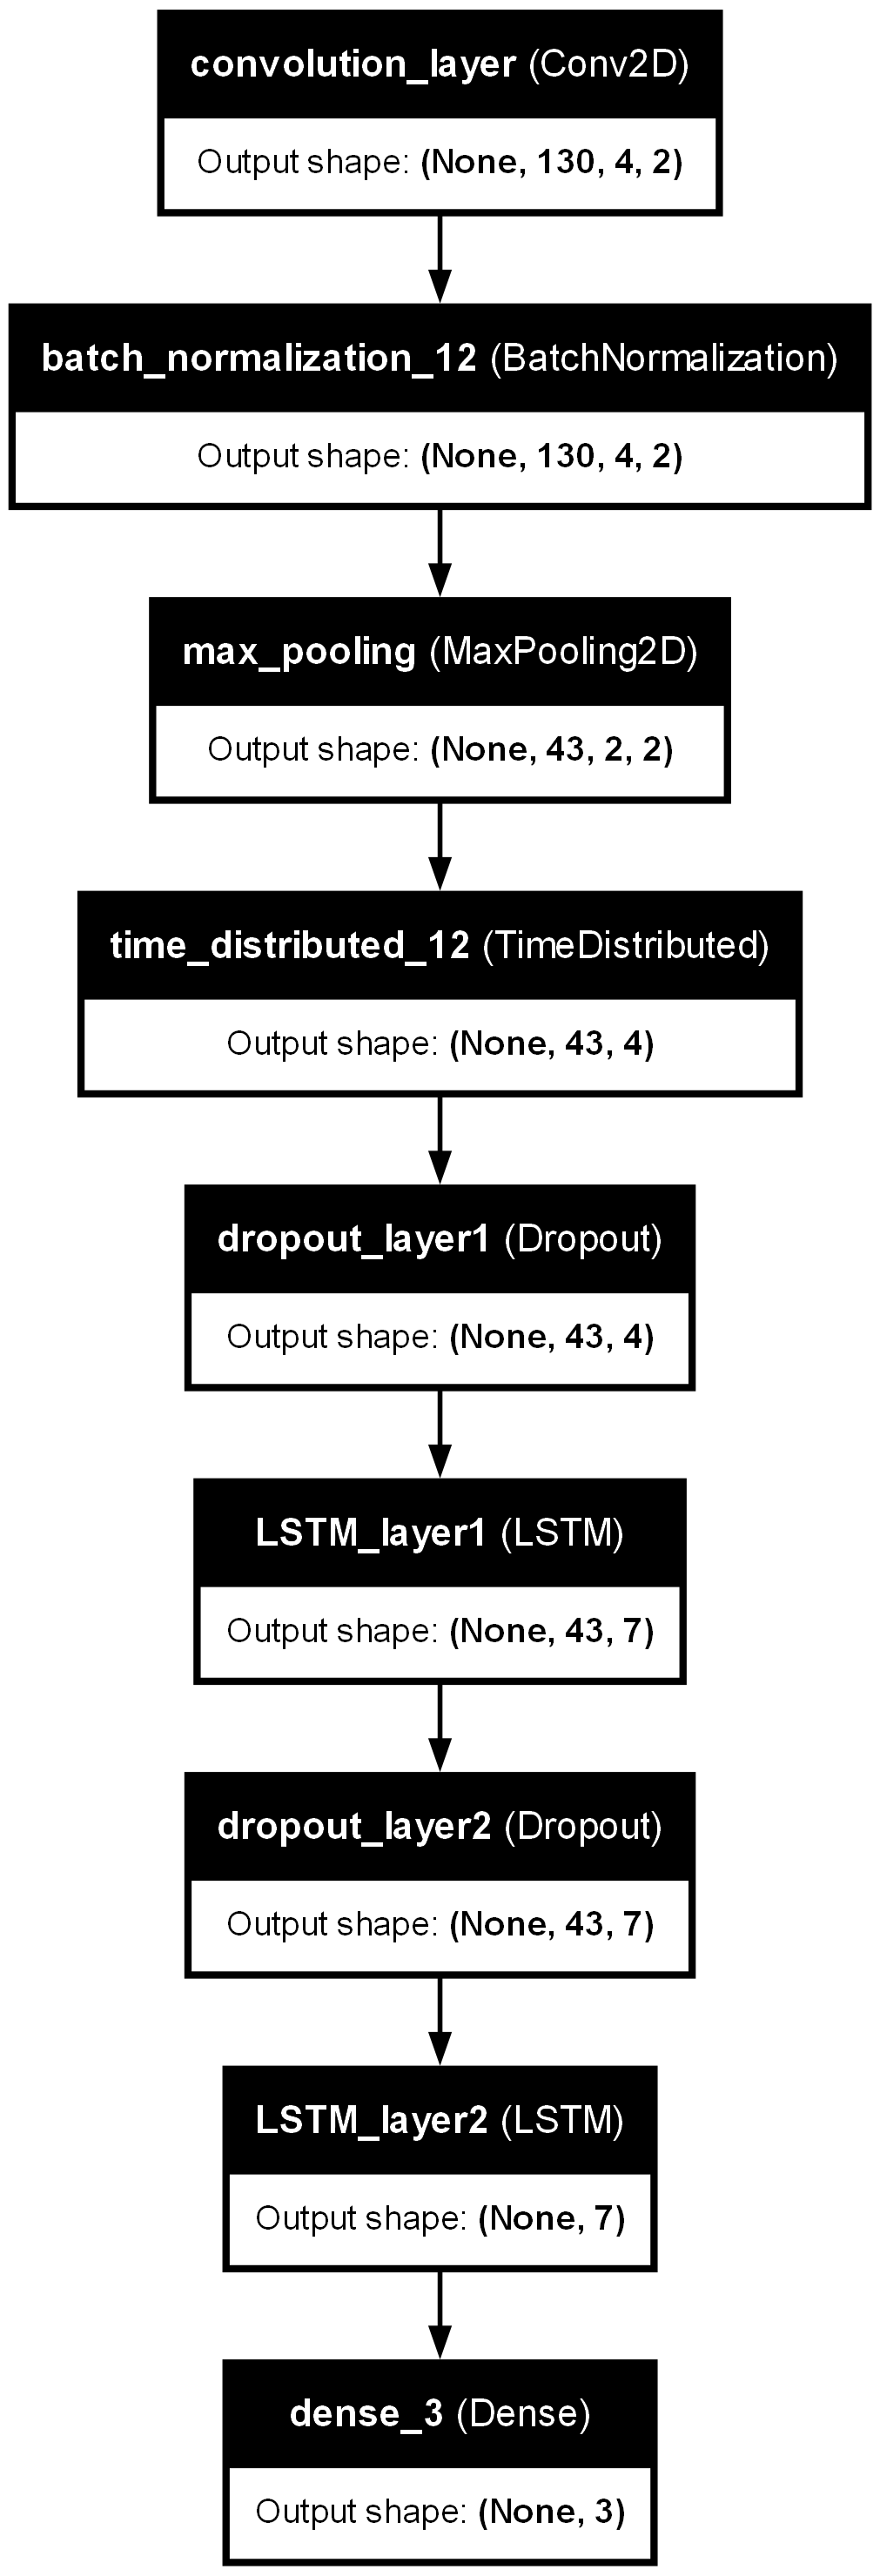

In [158]:
plot_model(model, to_file='../design/model_CNN_sentiment_plot.png', show_shapes=True, show_layer_names=True)

> Dump file model_hybrid_cnn_sentiment.h5

In [159]:
model.save('../model/model_hybrid_cnn_lstm_sentiment.h5')

> Dump file history_hybrid_cnn.pkl

In [160]:
with open('../history/history_hybrid_cnn.pkl', 'wb') as file:
    pickle.dump(history.history, file)

### 3.5 Evaluation test dataset

> Load file models_sentiment.h5

In [161]:
model_sentiment=load_model("../model/model_hybrid_cnn_lstm_sentiment.h5")

> Ploting learning curves:

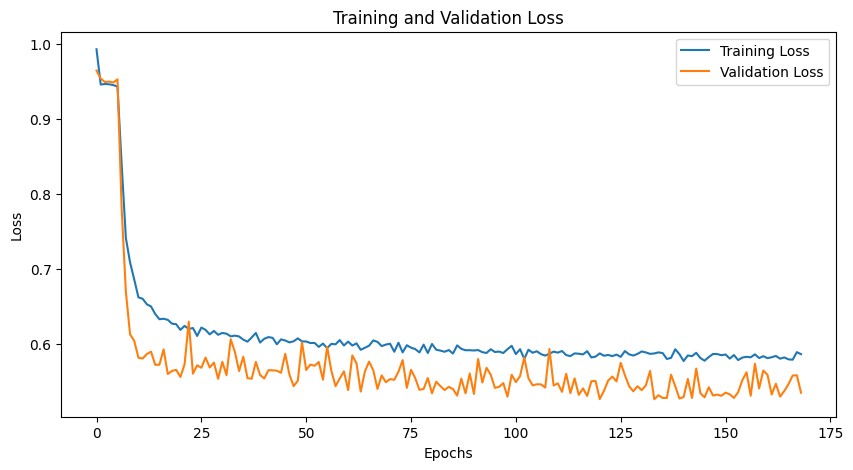

In [162]:
with open('../history/history_hybrid_cnn.pkl', 'rb') as file:
    history_lstm = pickle.load(file)
plt.figure(figsize=(10, 5))
plt.plot(history_lstm ['loss'], label='Training Loss')
plt.plot(history_lstm ['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

> predict  test dataset 

In [163]:
result = model_sentiment.predict(test_data)

70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


> First 10 lines of comments

In [164]:
predict_labels = np.argmax(result,axis=1)
print(predict_labels[0:10])
# Decode the predicted labels
predicted_labels_decoded = label_encoder.inverse_transform(predict_labels)
print(predicted_labels_decoded[0:10])


[2 0 2 0 2 0 2 2 2 2]
['Positive' 'Negative' 'Positive' 'Negative' 'Positive' 'Negative'
 'Positive' 'Positive' 'Positive' 'Positive']


> Data Preprocessing sample

In [165]:
def Preprocessing(comment):
    comment= remove_punctuation(comment.lower())
    comment= ViTokenizer.tokenize(comment)
    comment= remove_stopword(comment)
    comment= [remove_repeated_words(comment)]
    comment = wordseparation(comment)
    comment =np.expand_dims(comment_embedding(comment[0]),axis=0)
    return comment

> Predict one a new sample

In [166]:
comment = "Máy thiết kế quá đẹp ,dùng dk mấy hôm r thấy máy vẫn ổn ,tiếc là pin tụt quá nhanh ,pin sạc thì nhanh nóng 😌"
comment_preprocessed=Preprocessing(comment)
result_one = model_sentiment.predict(comment_preprocessed)
result_one = np.argmax(result_one,axis=1)
# Decode the predicted labels
print(label_encoder.inverse_transform(result_one))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
['Positive']


> Evaluate the model through Accuracy measures,Precision,Recall,F1-score,

In [167]:
accuracy_test = accuracy_score(y_test_encoded, predict_labels)
print(f'Accuracy: {accuracy_test:.4f}')
precision = precision_score(y_test_encoded, predict_labels, average='weighted')
print(f"Precision: {precision:.4f}")

recall = recall_score(y_test_encoded, predict_labels, average='weighted')
print(f"Recall: {recall:.4f}")

f1score = f1_score(y_test_encoded, predict_labels, average='weighted')
print(f"F1-score: {f1score}")

Accuracy: 0.8022
Precision: 0.7223
Recall: 0.8022
F1-score: 0.7601190459014987


c:\Users\hdang\.virtualenvs\DM-xmUrTfoX\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
